please read this notebook in Nbviewer as it has an option of showing or hiding code

### Summary of the project

Enron case reprsented the largest bankruptcy reorganization in American history at that time, and also it led the the biggest audit failure, with the demise of then top five firm - Andersen.

From a 90USD price per share, to a 1USD value represents the huge value loss and scam that happened in Enron. This case has been a point of interest for machine learning analysis because of the huge real-world impact that ML could help out and try to figure out what went wrong and how to avoid it in the future. It would be of great value to find a model that could potentially predict these types of events before much damage is done, so as to permit preventive action. Corporate governance, the stock market, and even the Government would be quite interested in a machine learning model that could signal potential fraud detections before hand.
The goal of the project is to develop an algorithm that will identify Enron employee who lkeily committed fraud. The dataset consists of Enron email and financial data compiled into a dictionary.  Each key-value pair in the dictionary corresponds to one person. The dictionary key is the person's name, and the value is another dictionary, which contains the names of all the features and their values for that person. The features in the data fall into three major types, namely financial features, email features and POI labels. 

#### Use of ML
Supervised machine learning algorithms can learn from a small dataset and process a large dataset to find trends and classify employees based on the training data. By identifying persons of interest using ML we could automate siginficant amount of work that would be done manually. 



In [18]:

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import math
from tester import test_classifier, dump_classifier_and_data

import sys
import pickle
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import math
from tester import test_classifier, dump_classifier_and_data
import numpy as np
from numpy import log
from numpy import sqrt
from numpy import float64
from numpy import nan
from time import time

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.lda import LDA
from sklearn.neural_network import BernoulliRBM
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.cluster import KMeans
import matplotlib
from feature_format import featureFormat, targetFeatureSplit
from sklearn.cross_validation import KFold
from sklearn.metrics import r2_score
from sklearn.feature_selection import SelectFromModel
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from tester import dump_classifier_and_data
from sklearn import preprocessing


In [5]:
### Created data_dict list containing all pickled data for analysis
import matplotlib
import sys
import pickle
sys.path.append("../tools/")

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi','salary'] # You will need to use more features

### Load the dictionary containing the dataset
import pickle
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)


#### Show all the features

In [59]:
### Created data_dict list containing all pickled data for analysis
features_all = []
for v in data_dict['WHALEY DAVID A']:
    features_all.append(v)
oldindex = features_all.index('poi')
features_all.insert(0, features_all.pop(oldindex))
print features_all
#print data_dict['SKILLING JEFFREY K']
len(features_all)
;    

['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other', 'from_this_person_to_poi', 'director_fees', 'deferred_income', 'long_term_incentive', 'email_address', 'from_poi_to_this_person']


''

### Outliers
To identify outliers we need to transfer data to dataframe.
We identified three clear outliers (TOTAL,  THE TRAVEL AGENCY, LOCKHART EUGENE E ). THE TRAVEL AGENCY and TOTAL are not real persons and should be taken out.  Mr. Lockhart does not have any data to his name.


In [7]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pandas as pd
def to_pandas(data_dict):
    df = pd.DataFrame(data_dict)
    df = df.convert_objects(convert_numeric=True) #converted objects to Numbeic, like POI which was boolean
    df = df.transpose() #original data_dict had all the info in rows instead of columns
    df.reset_index(level=0, inplace=True) #resets the index column to just a column
    columns = list(df.columns)
    columns[0] = 'name' #index column is renamed to names
    df.columns = columns
    return(df)
df = to_pandas(data_dict)
df.to_csv('dataset.csv')

/Users/azizmamatov/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


#### Parameters of data
* All emails adresses are NaN,
* 146 people, and 21 features.
* 128 non-POI and 18 POI
* Following names have this percentage of NaN values: 
* LOCKHART EUGENE E		95.238095
* GRAMM WENDY L	85.714286
* SCRIMSHAW MATTHEW	85.714286
* THE TRAVEL AGENCY IN THE PARK	85.714286
* WHALEY DAVID A	85.714286
* WODRASKA JOHN	85.714286
* WROBEL BRUCE	85.714286


In [70]:
#%%capture
df.shape
print df.groupby(['poi']).size() # we can see number of poi
df.describe();


,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,8.200000e+01,3.900000e+01,4.900000e+01,1.700000e+01,0.0,1.020000e+02,9.500000e+01,86.000000,86.000000,86.000000,...,6.600000e+01,9.300000e+01,146.000000,1.100000e+02,1.800000e+01,9.500000e+01,86.000000,86.000000,1.250000e+02,1.260000e+02
mean,2.374235e+06,1.642674e+06,-1.140475e+06,1.668049e+05,NaN,5.987054e+06,1.087289e+05,608.790698,64.895349,41.232558,...,1.470361e+06,9.190650e+05,0.123288,2.321741e+06,1.664106e+05,5.621943e+05,1176.465116,2073.860465,5.081526e+06,6.773957e+06
std,1.071333e+07,5.161930e+06,4.025406e+06,3.198914e+05,NaN,3.106201e+07,5.335348e+05,1841.033949,86.979244,100.073111,...,5.942759e+06,4.589253e+06,0.329899,1.251828e+07,4.201494e+06,2.716369e+06,1178.317641,2582.700981,2.906172e+07,3.895777e+07
min,7.000000e+04,-1.025000e+05,-2.799289e+07,3.285000e+03,NaN,3.285000e+03,1.480000e+02,12.000000,0.000000,0.000000,...,6.922300e+04,2.000000e+00,0.000000,-2.604490e+06,-7.576788e+06,4.770000e+02,2.000000,57.000000,1.480000e+02,-4.409300e+04
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,9.734362e+07,3.208340e+07,-8.330000e+02,1.398517e+06,NaN,3.117640e+08,5.235198e+06,14368.000000,528.000000,609.000000,...,4.852193e+07,4.266759e+07,1.000000,1.303223e+08,1.545629e+07,2.670423e+07,5521.000000,15149.000000,3.098866e+08,4.345095e+08


### 'Total' outlier.
Total is just a sum of values and should be taken out

In [9]:
df['name'].groupby(df['salary']).max()
df.sort_values(by=['salary','name'], ascending=[False, False]).head(5)


,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
130,TOTAL,97343619.0,32083396.0,-27992891.0,1398517.0,NaN,311764000.0,5235198.0,NaN,NaN,...,48521928.0,42667589.0,0.0,130322299.0,-7576788.0,26704229.0,NaN,NaN,309886585.0,434509511.0
122,SKILLING JEFFREY K,5600000.0,NaN,NaN,NaN,NaN,19250000.0,29336.0,108.0,88.0,...,1920000.0,22122.0,1.0,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0
79,LAY KENNETH L,7000000.0,202911.0,-300000.0,NaN,NaN,34348384.0,99832.0,36.0,123.0,...,3600000.0,10359729.0,1.0,14761694.0,NaN,1072321.0,2411.0,4273.0,103559793.0,49110078.0
47,FREVERT MARK A,2000000.0,6426990.0,-3367011.0,NaN,NaN,10433518.0,86987.0,21.0,242.0,...,1617011.0,7427621.0,0.0,4188667.0,NaN,1060932.0,2979.0,3275.0,17252530.0,14622185.0
105,PICKERING MARK R,300000.0,NaN,NaN,NaN,NaN,28798.0,31653.0,67.0,7.0,...,NaN,NaN,0.0,NaN,NaN,655037.0,728.0,898.0,1386690.0,28798.0


In [10]:
#### New dataframe with columns by names to determine NaN and similar data for our labels
df['name'].isnull().sum()
df_names = pd.DataFrame(data_dict)
df_names = df_names.convert_objects(convert_numeric=True)
#df_names.describe()

/Users/azizmamatov/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


#### Formula to determine NaN values for names
Nice summary, where first seven names have too many Nan values (more than 85%). LOCKHART EUGENE E does not have any values - all 20 columns are empty for him and he should be taken out of the list.
I took the below code from : https://stackoverflow.com/questions/26266362/how-to-count-the-nan-values-in-the-column-in-panda-data-frame

In [11]:
df_names.isnull().sum()
def missing_values_table(df): 
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum()/len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        return mis_val_table_ren_columns 
names_dataframe = missing_values_table(df_names) 
#sorting the names descending and showing first 10 names only
names_dataframe.sort_values(by=['Missing Values','% of Total Values'], ascending=[False, False]).head(10)




,Missing Values,% of Total Values
LOCKHART EUGENE E,20,95.238095
GRAMM WENDY L,18,85.714286
SCRIMSHAW MATTHEW,18,85.714286
THE TRAVEL AGENCY IN THE PARK,18,85.714286
WHALEY DAVID A,18,85.714286
WODRASKA JOHN,18,85.714286
WROBEL BRUCE,18,85.714286
CHRISTODOULOU DIOMEDES,17,80.952381
CLINE KENNETH W,17,80.952381
GILLIS JOHN,17,80.952381


In [12]:
#### New dataframe with columns by names to determine NaN and similar data for our labels
### Deleted outliers from data_dict
del data_dict['TOTAL']
del data_dict['THE TRAVEL AGENCY IN THE PARK']
del data_dict['LOCKHART EUGENE E']

###  New features
* 'Total stock value' = 'exercised_stock_options' + 'restricted_stock' + 'restricted_stock_deferred'
 
* 'Total payments'= 'salary' + 'deferral_payments' + 'bonus'+ 'expenses' + 'loan_advances'+ 'director_fees' 'deferred_income' + 'long_term_incentive'
Will divide features by financials, non-financial and label.

#### Log features
I added some new features, based on log of financial data, to make sure that the data is not widely dispersed as it is. Aslo I created features for ratio of emails to and from POI persons to total emails. This helped to establish relative numbers instead of absolute ones.

#### Non-financial features should be added with ratio based ones, like percentage of poi related message to total messages.
* 'poi_ratio_from' = 'from_this_person_to_poi' / 'from_messages'
* 'poi_ratio_to' = 'from_poi_to_this_person' / 'to_messages'


In [69]:
#divide features by labels and financial and non-financial
import pickle
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict_log = pickle.load(data_file)

financial_features = ['salary', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 
                      'restricted_stock', 'restricted_stock_deferred', 'total_stock_value', 'expenses',
                      'loan_advances','other', 'director_fees', 'deferred_income', 'long_term_incentive']
non_financials_features = ['to_messages', 'shared_receipt_with_poi', 'from_messages', 
                           'from_this_person_to_poi', 'from_poi_to_this_person']
poi_label = ['poi']
features_new = ["poi_ratio_from", 'poi_ratio_to',"total_payments_log", "salary_log","bonus_log",
                "total_stock_value_log", "exercised_stock_options_log"]

NANvalue = 'NaN'
for key in data_dict_log:
#creating new financial features            
    for feat in financial_features:
        try:
            data_dict_log[key][feat + '_log'] = math.log(data_dict_log[key][feat])
        except:
            data_dict_log[key][feat + '_log'] = NANvalue   
            
#creating new non_financial features   
    try: 
        data_dict_log[key]['poi_ratio_from'] = \
        1. * data_dict_log[key]['from_this_person_to_poi'] / data_dict_log[key]['from_messages']
        data_dict_log[key]['poi_ratio_to'] = \
        1. * data_dict_log[key]['from_poi_to_this_person'] / data_dict_log[key]['to_messages'] * 1.
    except:
        data_dict_log[key]['poi_ratio_from'] = NANvalue
        data_dict_log[key]['poi_ratio_to'] = NANvalue
            
            
for k, v in data_dict_log.iteritems():
    print data_dict_log[k]['salary_log'], \
data_dict_log[k]['poi_ratio_to'], data_dict_log[k]['total_payments_log'] 
    break

features_list = poi_label + financial_features + non_financials_features + features_new;


12.8098092096 0.0470879801735 13.8755015673


In [14]:
#### Creating featureFormat dataset
my_dataset = data_dict_log
data = featureFormat(my_dataset, features_list, sort_keys = True) 
labels, features = targetFeatureSplit(data)

### Scaling features
We may scale all the features via min-max algorithm. Some of the algorithms like logistics regression perform the best with scaled features.

In [15]:
#def scale_features(features):

from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
features = scaler.fit_transform(features)

#    return features
#scale_features(features)

In [16]:
#### Splitting data into training and test
from sklearn import cross_validation
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, test_size=0.3, random_state=42)


#### Try a varity of classifiers
There are various algorithms that we studies including the list below, and I decided to use GuassianNB, Decision tree classifier,  Logistic Regression and Gradient Boosting.

#### Need to select at least two algorithms, compare their performance and tune the parameters for two algorithms 

#### Decision tree classifier
We have some manual tuning to determine which parameters to add to each algorithm and adding/removing features. 

Parameter tuning is important because it optimizes an algorithm's performance on the data set. To measure the algorithm's performance, the data shoulld be validated and evaluated for different combinations of selected parameters. Algorithms are usually general in nature and are not  tuned to particular data set. Therefore, we should iteratively tune the algorithm until a satisfactory outcome is obtained.
##### As we can see below the maximum results are under 'min_samples_split' parameter of 2. However, none of the scores are acceptable

In [45]:
# Please name your classifier clf for easy export below.
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

clf = DecisionTreeClassifier()
clf.fit(features_train,labels_train)
#score = clf.score(features_test,labels_test)
pred= clf.predict(features_test)
acc=accuracy_score(labels_test, pred)
print 'Accuracy before tuning, decision tree =', acc
print 'precision before tuning, decision tree = ', precision_score(labels_test,pred)
print 'recall = before tuning, decision tree = ', recall_score(labels_test,pred)

split = [2,3,5,100,10000]
new_scores = []
for i in split:
    clf = DecisionTreeClassifier(min_samples_split=i)
    clf = clf.fit(features_train,labels_train)
    pred= clf.predict(features_test)
    acc=accuracy_score(labels_test, pred)
    new_scores.append(acc)
    precision = precision_score(labels_test,pred)
    new_scores.append(precision)
    recall = recall_score(labels_test,pred)
    new_scores.append(recall)

print 'Accuracy after tuning,', new_scores    

Accuracy before tuning, decision tree = 0.727272727273
precision before tuning, decision tree =  0.125
recall = before tuning, decision tree =  0.166666666667
Accuracy after tuning, [0.72727272727272729, 0.125, 0.16666666666666666, 0.70454545454545459, 0.1111111111111111, 0.16666666666666666, 0.72727272727272729, 0.125, 0.16666666666666666, 0.86363636363636365, 0.0, 0.0, 0.86363636363636365, 0.0, 0.0]


#### Logistic regression
Maximum scores are under 'C' parameter value of 10 and 10000 in our list. However, they are not sufficient for scoring.

In [47]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf = clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
acc=accuracy_score(labels_test, pred)
print 'Accuracy before tuning, logistic regression =', acc #clf.score(features_train, labels_train)
print 'recall before tuning, logistic regression = ', recall_score(labels_test, pred)
print 'precision before tuning, logistic regression = ', precision_score(labels_test, pred)

C = [5,10,100,10000]
new_scores = []
for i in C:
    clf = LogisticRegression(C=i)
    clf = clf.fit(features_train,labels_train)
    pred= clf.predict(features_test)
    acc=accuracy_score(labels_test, pred)
    new_scores.append(acc)
    precision = precision_score(labels_test,pred)
    new_scores.append(precision)
    recall = recall_score(labels_test,pred)
    new_scores.append(recall)

print 'Accuracy after tuning,', new_scores    

Accuracy before tuning, logistic regression = 0.772727272727
recall before tuning, logistic regression =  0.166666666667
precision before tuning, logistic regression =  0.166666666667
Accuracy after tuning, [0.79545454545454541, 0.20000000000000001, 0.16666666666666666, 0.72727272727272729, 0.20000000000000001, 0.33333333333333331, 0.77272727272727271, 0.16666666666666666, 0.16666666666666666, 0.79545454545454541, 0.2857142857142857, 0.33333333333333331]


####  Gradient Boosting
I used all the features in Gradient Boosting which is one of the ensemble methods and actually uses all the available features. Gradient boosting is using boosting methods where base estimators are built sequentially and one tries to reduce the bias of the combined estimator. The motivation is to combine several weak models to produce a powerful ensemble. As such, all of the available features are used, unless there are too many of them. 

Maximum scores are under 'max_depth' parameter value of 2 in our list and they stay the same once they increase. They provide acceptable scores under this environment, however it is not enough for tester.py file



In [48]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()
clf = clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
acc=accuracy_score(labels_test, pred)
print 'Accuracy before tuning, GradientBoosting  =', acc #clf.score(features_train, labels_train)
print 'recall before tuning,  = GradientBoosting', recall_score(labels_test, pred)
print 'precision before tuning, = GradientBoosting', precision_score(labels_test, pred)

maxdepth = [2, 5,10,100,10000]
new_scores = []
for i in maxdepth:
    clf = GradientBoostingClassifier(max_depth=i)
    clf = clf.fit(features_train,labels_train)
    pred= clf.predict(features_test)
    acc=accuracy_score(labels_test, pred)
    new_scores.append(acc)
    precision = precision_score(labels_test,pred)
    new_scores.append(precision)
    recall = recall_score(labels_test,pred)
    new_scores.append(recall)
print 'Accuracy after tuning,', new_scores    

Accuracy before tuning, GradientBoosting  = 0.863636363636
recall before tuning,  = GradientBoosting 0.166666666667
precision before tuning, = GradientBoosting 0.5
Accuracy after tuning, [0.88636363636363635, 0.66666666666666663, 0.33333333333333331, 0.81818181818181823, 0.25, 0.16666666666666666, 0.72727272727272729, 0.125, 0.16666666666666666, 0.72727272727272729, 0.125, 0.16666666666666666, 0.72727272727272729, 0.125, 0.16666666666666666]


### GaussianNB
This algorithm does not have any parameters to be adjusted however it needs to have good feature selection to work properly. As of now it does not provide acceptable results. I will need to explore feature selection and also experiment with scaling.

In [49]:
#GaussianNB, it has no parameters to adjust, so I will try selectKbest later
clf = GaussianNB()
clf.fit(features_train,labels_train)
pred= clf.predict(features_test)
acc=accuracy_score(labels_test, pred)
precision = precision_score(labels_test,pred)
recall = recall_score(labels_test,pred)
print "GaussianNB precision score", precision, 'recall score', recall, 'accuracy', acc


GaussianNB precision score 0.162162162162 recall score 1.0 accuracy 0.295454545455


### Feature Selection
The above results from GaussianNB came from using all our features and it clearly does not work. The linear algorithms like GaussianNB need to have an optimal number of features. Ensemble algorithm deals with this problem but it did not work in our case, as the tester.py file run showed suboptimal results.
Using too many features can also result in overfitting for linear algorithms. We will try the best features selection for GaussianNB algorithm.
Best five feature below return a very good score so we can focus on feature selection

In [50]:
clf = GaussianNB()

from sklearn.feature_selection import SelectKBest

# let's see what we can do with the best five features (k=5)
best_features = SelectKBest(k=5).fit(features_train, labels_train)

features_train_1 = best_features.transform(features_train)
features_test_1 = best_features.transform(features_test)

clf.fit(features_train_1,labels_train)
pred = clf.predict(features_test_1)
score = accuracy_score(labels_test, pred)
print 'recall ', recall_score(labels_test, pred)
print 'precision', precision_score(labels_test, pred)

print "BestK score: ", score

recall  1.0
precision 0.375
BestK score:  0.772727272727


#### Feature importances with forests of trees¶
We will build a graph to see which features are important for Gaussian NB and as we can see, majority of features are importants but first six features are especially important.  Features have decreasing importance over each feature. The most important features are payment related ones.
http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html 

Automatically created module for IPython interactive environment
Feature ranking:
1. feature salary (0.077746)
2. feature deferral_payments (0.075341)
3. feature total_payments (0.070364)
4. feature exercised_stock_options (0.064510)
5. feature bonus (0.062549)
6. feature restricted_stock (0.061644)
7. feature restricted_stock_deferred (0.054767)
8. feature total_stock_value (0.050924)
9. feature expenses (0.048972)
10. feature loan_advances (0.041997)
11. feature other (0.041933)
12. feature director_fees (0.041326)
13. feature deferred_income (0.040427)
14. feature long_term_incentive (0.040056)
15. feature to_messages (0.039222)
16. feature shared_receipt_with_poi (0.033064)
17. feature from_messages (0.031094)
18. feature from_this_person_to_poi (0.026213)
19. feature from_poi_to_this_person (0.021388)
20. feature poi_ratio_from (0.019322)
21. feature poi_ratio_to (0.017167)
22. feature total_payments_log (0.017072)
23. feature salary_log (0.008952)
24. feature bonus_log (0.008087)

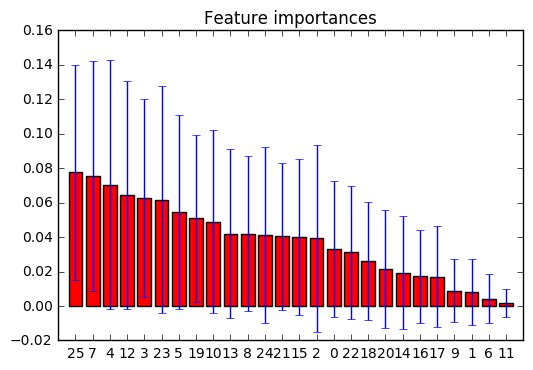

In [57]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

clf = GaussianNB()
clf.fit(features_train, labels_train)  # your feature and labels
model = SelectFromModel(clf, prefit=True)

# Build a classification task using 3 informative features
X, y = features_train, labels_train

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(len(features_list)-1):
    print("%d. feature %s (%f)" % (f+1, features_list[1:][f], importances[indices[f]]))
# Plot the feature importances of the forest
plt.title("Feature importances")
plt.bar(range(len(features_list)-1), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(len(features_list)-1), indices)
plt.xlim([-1, (len(features_list)-1)])
plt.show()    

#### Gridsearch on Gradient boosting 
N-estimators = 10, Max_depth = 1, All features are used
Returns acceptable results on our training data set but not on tester.py

In [42]:
from sklearn.model_selection import GridSearchCV
# applying GridSearch on GradientBoostingClassifier only

param_grid = {'n_estimators': [10, 100, 1000],'max_depth': [1, 2, 5]}


grid_search = GridSearchCV(GradientBoostingClassifier(), cv=10, n_jobs=-1, param_grid=param_grid)
grid_search.fit(features_train, labels_train)
clf = grid_search.best_estimator_

print clf
print grid_search.best_estimator_.score(features_test, labels_test)
print grid_search.grid_scores_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=1,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=10, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)
0.862068965517
[mean: 0.87931, std: 0.03421, params: {'n_estimators': 10, 'max_depth': 1}, mean: 0.83621, std: 0.06740, params: {'n_estimators': 100, 'max_depth': 1}, mean: 0.79310, std: 0.05349, params: {'n_estimators': 1000, 'max_depth': 1}, mean: 0.85345, std: 0.04773, params: {'n_estimators': 10, 'max_depth': 2}, mean: 0.81034, std: 0.06369, params: {'n_estimators': 100, 'max_depth': 2}, mean: 0.78448, std: 0.08050, params: {'n_estimators': 1000, 'max_depth': 2}, mean: 0.81897, std: 0.04036, params: {'n_estimators': 10, 'max_depth': 5}, mean: 0.81897, std: 0.0

#### Gridseach with PCA on GradientBoosting
Returns acceptable results on our training data set but not acceptable results on tester.py

In [43]:
# applying grid search on GradientBoostingClassifier but with pipeline which inludes PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
estimators = [('reduce_dim', PCA()), ('clf', GradientBoostingClassifier())]
pipe = Pipeline(estimators)
 

#param_grid = dict(selectkbest__k = range(20,25))

param_grid = {'reduce_dim__n_components': [2, 3],
               'clf__max_depth': [5,6]
          }

grid_search = GridSearchCV(pipe, cv=10, n_jobs=-1, param_grid = param_grid)
grid_search.fit(features_train, labels_train)
clf = grid_search.best_estimator_

print clf
print grid_search.best_estimator_.score(features_test, labels_test)
print grid_search.grid_scores_

Pipeline(steps=[('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_featur...=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False))])
0.862068965517
[mean: 0.85345, std: 0.06526, params: {'clf__max_depth': 5, 'reduce_dim__n_components': 2}, mean: 0.85345, std: 0.07689, params: {'clf__max_depth': 5, 'reduce_dim__n_components': 3}, mean: 0.85345, std: 0.06526, params: {'clf__max_depth': 6, 'reduce_dim__n_components': 2}, mean: 0.85345, std: 0.09227, params: {'clf__max_depth': 6, 'reduce_dim__n_components': 3}]


#### GridSearch CV on Gaussian NB - great results
As we discussed above, Gradient Boosting did not return acceptable results in tester.py and GaussianNB showed promising results when we experimented with feature selection. So we are going to apply GridSearchCV on GaussianNB.
I applied minimum 5 features as it showed good results in feature selections. I also tried applying PCA but it didn't return great results with this algorithm. When I took out the PCA, and showed acceptable results.

I selected Gaussian NB algorithm because it showed great results on selected features and without even applying PCA. Initially, I thought that the GradientBoosting will work however it did not on tester.py data, probably because of cross validations issues and the fact that there were too many features to be used.

Final top five features selected were as below:

1. salary 
2. deferral_payments
3. total_payments 
4. exercised_stock_options 
5. bonus 


#### Algorithm results

| Algorithm | Accuracy | Precision | Recall | F1 | F2 | Total predictions | True positives | False positives | False negatives | True negatives
|---|---|---|---|---|---|---|---|---|---|---|
|GaussianNB()|0.84673|0.40743|0.32900|0.36404|0.34217|15000|658|957|1342|12043|
|GradientBoostingClassifier()| 0.88000|0.93478|0.10750|0.19283|0.13062|15000|215|15|1785|12985|

In [58]:
scaler = preprocessing.MinMaxScaler()
features = scaler.fit_transform(features)
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

GNB = GaussianNB()
DTC = DecisionTreeClassifier()
LR = LogisticRegression()

param_grid = {'selectkbest__k': range(5,27)}

# Create the pipline to use in Task 5
pipeline = Pipeline([#('reduce_dim', PCA()),
                     ('selectkbest', SelectKBest()),
                    ('naive_bayes', GNB), #('min_max_scaler', scaler)
                    ])
#('min_max_scaler', scaler)]
grid_search = GridSearchCV(pipeline, cv=10, n_jobs=-1, param_grid = param_grid)
grid_search.fit(features_train, labels_train)
clf = grid_search.best_estimator_
pred = clf.predict(features_test)
#acc=accuracy_score(labels_test, pred)
#precision = precision_score(labels_test,pred)
#recall = recall_score(labels_test,pred)

print clf
print grid_search.best_estimator_.score(features_test, labels_test)
print grid_search.best_params_,


Pipeline(steps=[('selectkbest', SelectKBest(k=8, score_func=<function f_classif at 0x10bec7938>)), ('naive_bayes', GaussianNB(priors=None))])
0.75
{'selectkbest__k': 8}


#### Parameter Tuning:
Parameters of algorithm play a decisive role in the quality of the prediction. If the parameters are not tuned well then the resulting accuracy score, recall and precision scores would be either not acceptable or below the desired standard. Algorithms are usually very general in natures and as such should be tuned. 
However, no parameter tuning was required for GaussianNB except for careful feature selection.
For other algorithms I used you can see parameter tuning above where I was experimenting with specific parameters for each algorithm.

#### Validation
Validation allows to find a suitable result between bias and variance. High variance will result in overfitting the data while high bias will result in underfiting the data. As such, the data should be carefully split into training and testing sets. 
The train_test_split method was used to split the provided dataset (30% test, - 70% train), and then the GridSearchCV.

#### Evaluation
Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance. [relevant rubric item: “usage of evaluation metrics”]

I used three evaluation metrics - recall, precision and accuracy. After tuning they equalled: 
* Accuracy = 0.86, 
* recall = 0.33, 
* precision 0.41.

Accuracy is not the best evaluation metric because of the sparcity of the label - POI. That is why precision and evaluation is used. Precision is the ratio of the model being correct for positive label to the total times of guess as positive labels. A higher precision score means less false positives.
Recall ks the ratio of model being correct for positive labels as to total number of positive labels. A higher recall score means less false negatives.
Recall is the most important criteria as we would need to find all people who were involved and then we would gradually clear them if they are innocent during the investigation.

### References
* http://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting
* http://scikit-learn.org/stable/modules/pipeline.html
* http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
* https://stackoverflow.com/questions/26266362/how-to-count-the-nan-values-in-the-column-in-panda-data-frame
* http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/
